In [46]:
import torch
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.5.1


## Utility functions

In [47]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    sde_flow = stochastic_interpolant.SDEIntegrator(
        b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    with torch.no_grad():
        x0_tests  = base(bs)
        xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
        xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
        # ([1, bs, dim], [bs])
        x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_sde, xf_pflow, logpx_pflow


def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    _, _, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    xf_sde, xf_pflow, logpx_pflow = compute_likelihoods(
        b, s, interpolant, n_save, n_step, eps, likelihood_bs
    )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", loss, b_grad, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    axes[0].plot(epochs, data_dict['b_losses'], label="b")
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from SDE.
    axes[1].scatter(
        xf_sde[:,0], xf_sde[:,1], vmin=0.0, vmax=0.05, alpha = 0.2)
    axes[1].set_xlim(-5,5)
    axes[1].set_ylim(-6.5,6.5)
    axes[1].set_title("Samples from SDE", fontsize=14)


    # plot samples from pflow
    axes[2].scatter(
        xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    axes[2].set_xlim(-5,5)
    axes[2].set_ylim(-6.5,6.5)
    axes[2].set_title("Samples from PFlow", fontsize=14)


    # plot likelihood estimates.
    axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    axes[3].set_title(r"$\log p$ from PFlow")
    axes[3].legend(loc='best')
    axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    


def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_b  : Any,
    opt_s  : Any,
    sched_b: Any, 
    sched_s: Any,
):
    """
    Take a single step of optimization on the training set.
    """
    opt_b.zero_grad()
    opt_s.zero_grad()


    # construct batch
    x0s = base(bs)
    x1s = target_rhombus(bs)
    ts  = torch.rand(size=(bs,))


    # compute the loss
    loss_start = time.perf_counter()
    loss_b     = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_s     = loss_fn_s(s, x0s, x1s, ts, interpolant)
    loss_val   = loss_b + loss_s
    loss_end   = time.perf_counter()


    # compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_s.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s.parameters(), float('inf'))])
    backprop_end = time.perf_counter()


    # perform the update.
    update_start = time.perf_counter()
    opt_b.step()
    opt_s.step()
    sched_b.step()
    sched_s.step()
    update_end = time.perf_counter()


    if counter < 5:
        print(f'[Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')


    return loss_val.detach(), loss_b.detach(), loss_s.detach(), b_grad.detach(), s_grad.detach()

### Define target

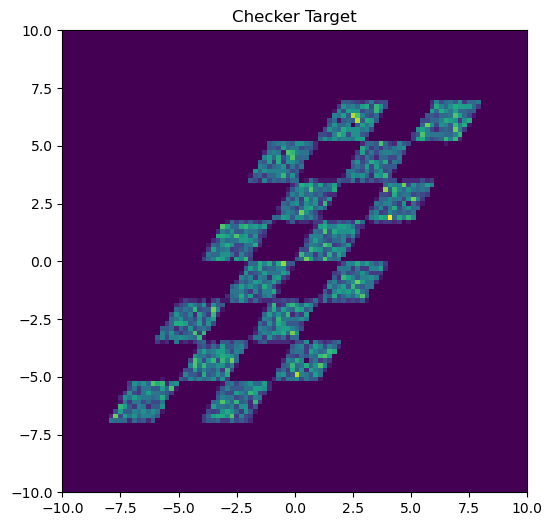

Batch Shape: (10000, 2)


In [55]:

ndim = 2
def target(bs):
    x1 = torch.rand(bs) * 4 - 2
    x2_ = torch.rand(bs) - torch.randint(2, (bs,)) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)

def target_rect(bs,
                w=1.0, h=0.1,          # rectangle (tile) width & height
                layers_x=4, layers_y=4, # how many tiles across (x) and down (y) in the checker
                scale=4.0,              # final global scaling (like your *2)
                device=None, dtype=None):
    """
    Rectangular checkerboard with adjustable aspect ratio and number of layers.

    - Tiles are width w and height h.
    - layers_x, layers_y control how many tiles we place horizontally/vertically.
    - Classic checker staggering: every odd column is shifted by +h.
    - Output is centered around (0,0) and then scaled by `scale`.
    """
    if device is None:
        device = torch.device('cpu')
    if dtype is None:
        dtype = torch.get_default_dtype()

    # choose a column and a vertical "base strip"
    col = torch.randint(layers_x, (bs,), device=device)
    base_row = torch.randint(layers_y, (bs,), device=device)

    # x within the chosen column tile
    x_in = torch.rand(bs, dtype=dtype, device=device) * w
    x = (col.to(dtype) + x_in / w) * w  # in [0, layers_x*w)

    # y within a checker tile, staggered by column parity
    y_in = torch.rand(bs, dtype=dtype, device=device) * h
    # rows span height 2*h per pair because of staggering (checker alternation)
    y = (base_row.to(dtype) * 2.0 * h) + ((col % 2).to(dtype) * h) + y_in  # in [0, 2*layers_y*h)

    # center to ~zero and scale
    x = x - (layers_x * w) / 2.0
    y = y - (layers_y * h)
    out = torch.stack([x, y], dim=1) * scale
    return out


def target_rhombus(bs,
                   s=1.0,                 # side length of the rhombus (both edges equal)
                   angle_deg=60.0,        # interior angle between edges a and b (0<angle<180, != 0/180)
                   layers_x=4,            # how many tiles along the 'a' direction
                   layers_y=4,            # how many (checker) pairs along the 'b' direction
                   scale=2.0,
                   device=None, dtype=None):
    """
    True rhombus checkerboard sampler.

    Construction:
      - Lattice edges: a and b with |a|=|b|=s and angle `angle_deg` between them.
      - Checker staggering: along b, every odd a-column is shifted by +b/2 (i%2).
      - Indices: u in [0, layers_x), v in [0, 2*layers_y) with parity offset.
      - We sample uniformly inside a single rhombus cell by adding u_in, v_in ∈ [0,1).

    Output:
      Tensor of shape [bs, 2].
    """
    if device is None:
        device = torch.device('cpu')
    if dtype is None:
        dtype = torch.get_default_dtype()

    # Integer tile indices for the checker tiling
    i = torch.randint(layers_x, (bs,), device=device)           # column along a
    j = torch.randint(layers_y, (bs,), device=device)           # row-pair along b

    # Uniform offsets inside a rhombus cell
    u_in = torch.rand(bs, device=device, dtype=dtype)           # along a
    v_in = torch.rand(bs, device=device, dtype=dtype)           # along b

    # Staggering to make a checker: v steps by 2, with +1 for odd columns
    u = i.to(dtype) + u_in                                      # [0, layers_x)
    v = (2 * j + (i % 2)).to(dtype) + v_in                      # [0, 2*layers_y)

    # Build rhombus lattice basis (equal side lengths, non-orthogonal)
    theta = math.radians(angle_deg)
    a = torch.tensor([s, 0.0], device=device, dtype=dtype)                      # |a|=s
    b = torch.tensor([s * math.cos(theta), s * math.sin(theta)],                # |b|=s
                     device=device, dtype=dtype)

    # Center the cloud approximately at the origin
    u_c = layers_x / 2.0
    v_c = layers_y       # because v spans 2*layers_y "b-steps"
    pts = (u - u_c).unsqueeze(1) * a + (v - v_c).unsqueeze(1) * b

    return pts * scale




target_samples = grab(target_rhombus(10000))


fig = plt.figure(figsize=(6,6))
plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-10,10],[-10,10]]);
plt.title("Checker Target")
plt.show()


print("Batch Shape:", target_samples.shape)
# target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [56]:
base_loc     = torch.zeros(ndim)
base_var     = torch.ones(ndim)
base         = prior.SimpleNormal(base_loc, 2.0*base_var)
base_samples = grab(base(20000))

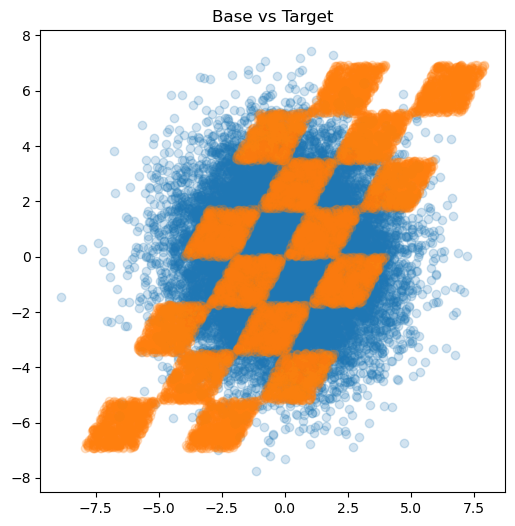

In [50]:
fig = plt.figure(figsize=(6,6,))
plt.scatter(base_samples[:,0], base_samples[:,1],  label = 'base', alpha = 0.2);
plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Bimodal Target")
plt.title("Base vs Target")
plt.show()

### Define Interpolant: A one sided interpolant, meaning that $x_0 \sim N(0,1)$

In [51]:
# gamma_type = 'brownian'
path = 'one-sided-trig'
interpolant  = stochastic_interpolant.Interpolant(path=path, gamma_type=None)

### Define losses for b and s

In [52]:
loss_fn_b = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-b')
loss_fn_s = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-s')

### Define velocity field and optimizers

In [53]:
base_lr      = 2e-3
hidden_sizes = [256, 256, 256, 256]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False


b       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
s       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_b   = torch.optim.Adam(b.parameters(), lr=base_lr)
opt_s   = torch.optim.Adam(s.parameters(), lr=base_lr)
sched_b = torch.optim.lr_scheduler.StepLR(optimizer=opt_b, step_size=1500, gamma=0.4)
sched_s = torch.optim.lr_scheduler.StepLR(optimizer=opt_s, step_size=1500, gamma=0.4)


eps          = torch.tensor(0.5)
N_era        = 14
N_epoch      = 500
plot_bs      = 5000  # number of samples to use when plotting
bs           = 2000    # number of samples from rho_0 in batch
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]


if print_model:
    print("Here's the model b, s:", b, s)

In [54]:
data_dict = {
    'losses': [],
    'b_losses': [],
    's_losses': [],
    'b_grads': [],
    's_grads': [],
    'times': [],
    'logps_pflow': [],
}

counter = 1
for i, era in enumerate(range(N_era)):
    for j, epoch in enumerate(range(N_epoch)):
        loss, b_loss, s_loss, b_grad, s_grad = train_step(bs, interpolant, opt_b, opt_s, sched_b, sched_s,
        )


        if (counter - 1) % metrics_freq == 0:
            log_metrics(b, s, interpolant, n_save, n_step, bs, b_loss, 
                        s_loss, loss, b_grad, s_grad, eps, data_dict)


        if (counter - 1) % plot_freq == 0:
            make_plots(b, s, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, eps, data_dict)


        counter+=1

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [2]:
import torch

def target_rect(bs: int, cell_width: float = 1.0, cell_height: float = 0.5, x_min: float = -2.0, x_max: float = 2.0):
    """
    Rectangular checkerboard target with adjustable cell width and height.
    - cell_width: width of each column in x-units
    - cell_height: height of each row band in y-units
    Keeps the same construction as the base checker, but generalizes the
    horizontal column width and vertical band height.
    """
    # Sample x uniformly across the horizontal range
    x1 = torch.rand(bs) * (x_max - x_min) + x_min

    # Sample y inside one of two bands: [0, cell_height) or [-2, -2 + cell_height)
    y_band = torch.rand(bs) * cell_height
    band_selector = torch.randint(2, (bs,))
    y2_ = torch.where(band_selector == 0, y_band, y_band - 2.0)

    # Alternate vertical offset by column parity computed from adjustable column width
    col_parity = torch.floor((x1 - x_min) / cell_width) % 2
    y2 = y2_ + col_parity * cell_height

    return torch.cat([x1[:, None], y2[:, None]], dim=1) * 2


In [3]:
import torch

def target_rhombus(bs: int, diag_x: float = 1.0, diag_y: float = 1.0, grid_x: float = 1.0, grid_y: float = 1.0, x_min: float = -2.0, x_max: float = 2.0):
    """
    Rhombus checkerboard target by shearing the square checker grid.
    - diag_x, diag_y: primary rhombus diagonals in x and y (controls rhombus shape)
    - grid_x, grid_y: spacing of the underlying grid before shear
    Samples are generated on a sheared grid where parity alternates like a checkerboard.
    """
    # Base x position
    x1 = torch.rand(bs) * (x_max - x_min) + x_min

    # Choose band (two alternating bands along y direction)
    band_selector = torch.randint(2, (bs,))

    # Shear factor to create rhombus (tilt cells by shifting y as a function of x)
    # Shear by s = diag_y/diag_x, and scale vertical spacing by grid_y
    shear = (diag_y / (diag_x + 1e-8))

    # Local y coordinate within a band
    local_y = torch.rand(bs) * grid_y

    # Compute column parity from a slanted coordinate system
    col_index = torch.floor((x1 - x_min) / grid_x)
    col_parity = torch.remainder(col_index, 2)

    # Place into alternating bands, then shear by x
    y2 = torch.where(band_selector == 0, local_y, local_y - 2.0)
    y2 = y2 + col_parity * (grid_y / 2.0) + shear * (x1 - x_min)

    return torch.cat([x1[:, None], y2[:, None]], dim=1) * 2


In [ ]:
def train_step(
    bs,
    interpolant,
    opt_b,
    opt_s,
    sched_b,
    sched_s,
    base_fn=None,
    target_fn=None,
    base_kwargs=None,
    target_kwargs=None,
):
    """
    Single optimization step.

    Pass custom data generators via base_fn/target_fn. If None, falls back to
    globals: base and target (or target_rhombus if target is absent).

    - base_fn: callable like base(bs, **base_kwargs)
    - target_fn: callable like target(bs, **target_kwargs)
    - base_kwargs/target_kwargs: optional dicts forwarded to the callables
    """
    # Default to globally defined functions if not provided
    if base_fn is None:
        base_fn = globals().get('base')
    if target_fn is None:
        # Prefer `target` if present; else fall back to `target_rhombus`
        target_fn = globals().get('target', globals().get('target_rhombus'))

    base_kwargs = {} if base_kwargs is None else base_kwargs
    target_kwargs = {} if target_kwargs is None else target_kwargs

    opt_b.zero_grad()
    opt_s.zero_grad()

    # construct batch
    x0s = base_fn(bs, **base_kwargs)
    x1s = target_fn(bs, **target_kwargs)
    ts  = torch.rand(size=(bs,))

    # compute the loss
    loss_start = time.perf_counter()
    loss_b     = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_s     = loss_fn_s(s, x0s, x1s, ts, interpolant)
    loss_val   = loss_b + loss_s
    loss_end   = time.perf_counter()

    # compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_s.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s.parameters(), float('inf'))])
    backprop_end = time.perf_counter()

    # perform the update
    update_start = time.perf_counter()
    opt_b.step()
    opt_s.step()
    sched_b.step()
    sched_s.step()
    update_end = time.perf_counter()

    if counter < 5:
        print(f'[Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')

    return loss_val.detach(), loss_b.detach(), loss_s.detach(), b_grad.detach(), s_grad.detach()


#### Passing custom base/target into `train_step`

Example usages:

```python
# Use rectangular checker as target
loss, b_loss, s_loss, b_grad, s_grad = train_step(
    bs, interpolant, opt_b, opt_s, sched_b, sched_s,
    base_fn=base,                # or a custom base
    target_fn=target_rect,       # or target_rhombus
)

# If your target/base accept extra kwargs, pass them via dicts
loss, b_loss, s_loss, b_grad, s_grad = train_step(
    bs, interpolant, opt_b, opt_s, sched_b, sched_s,
    base_fn=base,
    target_fn=target_rhombus,
    target_kwargs={"diag_x": 1.0, "diag_y": 0.5},
)
```
